In [1]:
from pyscf import gto, scf, md
import re
import pickle
import numpy as np
import os 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt 
from datetime import datetime

In [2]:
def run_md_simulation():
    h2 = gto.Mole()
    h2.atom = [['H', (0.7, 0, 0)], ['H', (-0.7, 0, 0)]]
    h2.basis = 'ccpvdz'
    h2.unit = 'B'
    h2.build() 
    h2._atom
    mf = scf.RHF(h2)
    mf.kernel()
    mycas = mf.CASSCF(2, 2)
    myscanner = mycas.nuc_grad_method().as_scanner()

    # Generate the integrator
    # sets the time step to 5 a.u. and will run for 100 steps
    # or for 50 a.u.
    myintegrator = md.NVE(myscanner,
                                dt=1,
                                steps=1200,
                                energy_output="BOMD.md.energies",
                                trajectory_output="BOMD.md.xyz",
                                verbose=0).run()

    # Note that we can also just pass the CASSCF object directly to
    # generate the integrator and it will automatically convert it to a scanner
    # myintegrator = pyscf.md.NVE(mycas, dt=5, steps=100)

    # Close the file streams for the energy and trajectory.
    myintegrator.energy_output.close()
    myintegrator.trajectory_output.close()


In [3]:
def create_grid_coordinates(ticks=30):
    raw_data = open("../../data/BOMD.md.xyz", "r").read() + "2\n"
    raw_data = raw_data.split("MD Time")[1:]
    R = []
    for n in range(len(raw_data)):
        data_point = raw_data[n]
        data_point = data_point.split("\n")[1:-2]
        data_point = [re.sub(r'\s+', ',', coords).split(",") for coords in data_point]
        data_point = [[x, y, z] for [atom, x, y, z] in data_point]
        R.append(data_point)
    R = np.array(R, dtype=np.float32)
    R_reshaped = R.reshape((len(raw_data) * 2, 3))
    max_abs_value = 2 * np.sqrt((R_reshaped * R_reshaped).sum(axis=-1)).max()
    # since the hydrogen molecule is always centered around the origin, grid axis can be chosen to be symmetrical wrt origin
    array = np.linspace(-max_abs_value / 2, max_abs_value, ticks)
    coords = np.array([[x, y, 0] for x in array for y in array])
    data_dict = {"R": R, "coords": coords}
    pickle.dump(data_dict, open(f"../../data/md_h2_R_coords.npz", "wb"))

In [4]:
def random_sphere_points(num_points):
    np.random.seed(0)
    x = np.random.normal(0, 1, num_points)
    y = np.random.normal(0, 1, num_points)
    z = np.random.normal(0, 1, num_points)

    points = np.vstack((x, y, z))
    norms = np.linalg.norm(points, axis=0)
    points = points / norms
    points = points.tolist()
    [x, y, z] = points

In [5]:
def regular_sphere_points(radius, center, azimut_angle):
    points = []
    n_azimut = np.pi / azimut_angle
    d_azi = radius * np.pi / n_azimut
    for theta_azi in np.arange(azimut_angle, np.floor(np.pi / azimut_angle) * azimut_angle, azimut_angle):
        r_polar = np.sin(theta_azi) * radius
        polar_angle_increment = d_azi / r_polar
        for phi_pol in np.arange(0, np.floor(2 * np.pi / polar_angle_increment) * polar_angle_increment, polar_angle_increment):
            x = radius * np.sin(theta_azi) * np.cos(phi_pol) + center[0]
            y = radius * np.sin(theta_azi) * np.sin(phi_pol) + center[1]
            z = radius * np.cos(theta_azi) + center[2]
            points.append([x, y, z]) 
    points = np.array(points).T.tolist()
    [x, y, z] = points
    return points

In [6]:
R_data = np.load("../../data/md_h2_R_coords.npz", allow_pickle=True)
R_total = R_data["R"]
R = R_total[0]
(R[0] + R[1]) / 2

array([0., 0., 0.], dtype=float32)

In [7]:
R_data = np.load("../../data/md_h2_R_coords.npz", allow_pickle=True)
R_total = R_data["R"]
sphere_coords = []
line_coords = []
for R in R_total:
    azimut_angle = np.pi / 8
    center = (R[0] + R[1]) / 2
    radius = 0.3
    coords_per_R = []
    for atom in R:
        sphere_points = regular_sphere_points(radius, atom, azimut_angle)
        coords_per_R.append(sphere_points)
    sphere_coords.append(coords_per_R)
    line_points = [(np.array(R[0]) + i / 11 * (np.array(R[1]) - np.array(R[0]))).tolist() for i in range(1, 11)]
    line_coords.append(line_points)

sphere_coords = np.array(sphere_coords)
sphere_coords = np.transpose(sphere_coords, (0, 3, 1, 2))
(a, b, c, _) = sphere_coords.shape
sphere_coords = np.reshape(sphere_coords, newshape=(a, c * b, 3))

line_coords = np.array(line_coords)
coords = np.concatenate((line_coords, sphere_coords), axis=1)
non_grid_data_dict = {
    "R": R_total,
    "non_grid_coords": coords
}
with open("../../data/md_h2_R_non_grid_coords.npz", "wb") as f:
    pickle.dump(non_grid_data_dict, f)

In [8]:
def create_densities_and_corrs(length, overwrite=False, with_corrs=False, verbose=1, corr_cutoff=0.05):
    if overwrite:
        data_dict = {key: None for key in ["R", "densities", "corrs", "coords"]}
        with open("../../data/md_h2.npz", "wb") as f:
            pickle.dump(data_dict, f)
    R_and_coords = np.load("../../data/md_h2_R_non_grid_coords.npz", allow_pickle=True)
    R = R_and_coords["R"]
    all_coords = R_and_coords["non_grid_coords"]
    i = 0
    if length == -1:
        length = len(R)
    for i in range(length):
        [R1, R2] = R[i]
        coords = all_coords[i]
        if verbose == 1:
            print(i / length)
            i += 1
        atom_data = [[1, R1.tolist()], [1, R2.tolist()]]
        mol = gto.M()
        mol.atom = atom_data
        mol.basis = "ccpvdz"
        mol.build()
        hf = scf.RHF(mol).run(verbose=0)
        rdm1 = hf.make_rdm1()
        rdm2 = hf.make_rdm2()
        ao_vals = np.array(mol.eval_ao("GTOval_sph", coords))
        densities_for_molecule = np.einsum("ij,ni,nj->n", rdm1, ao_vals, ao_vals)
        atom_data = [[x, y, z] for [i, [x, y, z]] in atom_data]
        temp_dict = {
            "R": np.array(atom_data, dtype=np.float32)[np.newaxis, :, :], 
            "densities": densities_for_molecule[np.newaxis, :],
            "corrs": None,
            "coords": coords[np.newaxis, :]
        }
        
        if with_corrs:
            corrs_for_molecule = 0.5 * np.einsum("ijkl,ni,nj,mk,ml->nm", rdm2, ao_vals, ao_vals, ao_vals, ao_vals)
            temp_dict["corrs"] = corrs_for_molecule[np.newaxis, :]

        file_name = "../../data/md_h2.npz"
        current_data = np.load(file_name, allow_pickle=True)
        for key in ["R", "densities", "coords", "corrs"]:
            if current_data[key] is None:
                current_data[key] = temp_dict[key]
            else:
                current_data[key] = np.concatenate((current_data[key], temp_dict[key]))
        with open("../../data/md_h2.npz", "wb") as f:
            pickle.dump(current_data, f)
        

In [9]:
create_densities_and_corrs(-1, overwrite=True, with_corrs=True)

0.0
0.0008333333333333334
0.0016666666666666668
0.0025
0.0033333333333333335
0.004166666666666667
0.005
0.005833333333333334
0.006666666666666667
0.0075
0.008333333333333333
0.009166666666666667
0.01
0.010833333333333334
0.011666666666666667
0.0125
0.013333333333333334
0.014166666666666666
0.015
0.015833333333333335
0.016666666666666666
0.0175
0.018333333333333333
0.019166666666666665
0.02
0.020833333333333332
0.021666666666666667
0.0225
0.023333333333333334
0.024166666666666666
0.025
0.025833333333333333
0.02666666666666667
0.0275
0.028333333333333332
0.029166666666666667
0.03
0.030833333333333334
0.03166666666666667
0.0325
0.03333333333333333
0.034166666666666665
0.035
0.035833333333333335
0.03666666666666667
0.0375
0.03833333333333333
0.03916666666666667
0.04
0.04083333333333333
0.041666666666666664
0.0425
0.043333333333333335
0.04416666666666667
0.045
0.04583333333333333
0.04666666666666667
0.0475
0.04833333333333333
0.049166666666666664
0.05
0.050833333333333335
0.0516666666666666

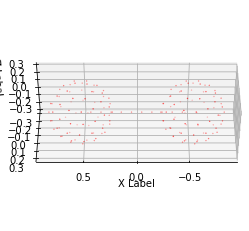

In [10]:
file = np.load("../../data/md_h2.npz", allow_pickle=True)
plot_points = file["coords"][0]
x = plot_points.T[0]
y = plot_points.T[1]
z = plot_points.T[2]
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the points
ax.scatter(x, y, z, c='r', marker='o', s=0.1)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(45, 90)
ax.set_aspect('equal')
plt.show()

In [11]:
file["coords"].shape

(1200, 166, 3)